In [1]:
# Loading all the necessary modules
%matplotlib notebook
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import LogNorm

# REMEMBER THE SURROGATE MODEL FILE WHERE THE RBF CLASS IS IMPLEMENTED
import surrogate as sg
from importlib import reload
reload(sg);


# 2D Diamond Airfoil Test Function


## Using the HiSA density based OpenFOAM solver:

<table><tr>
    <td> 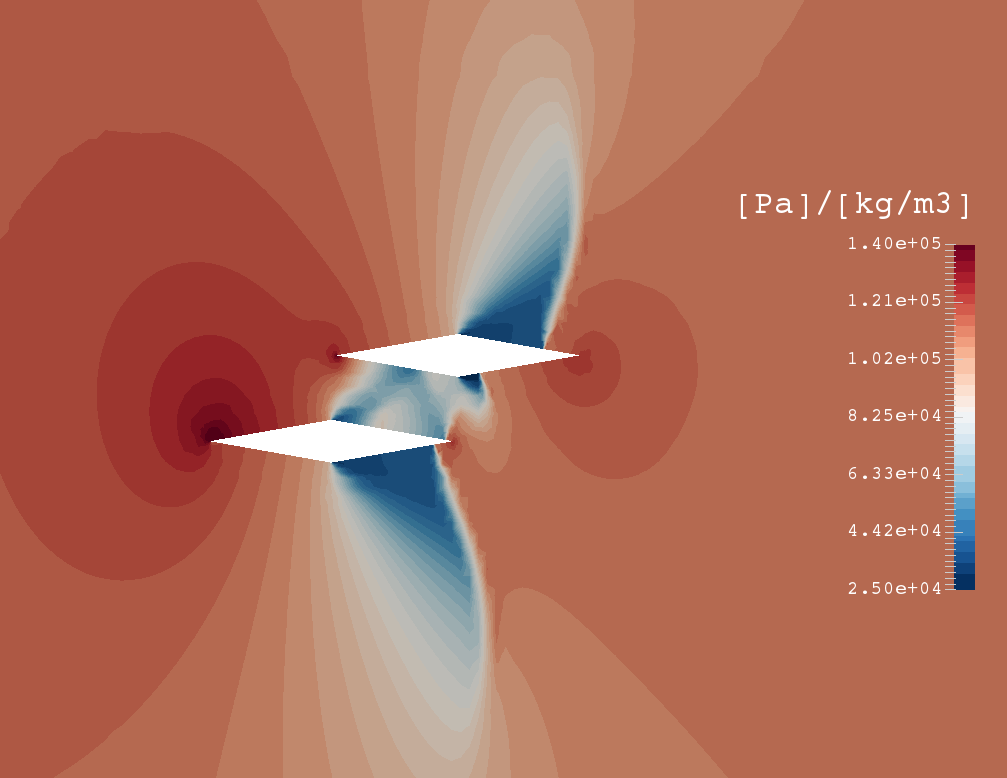 </td>
    <td> 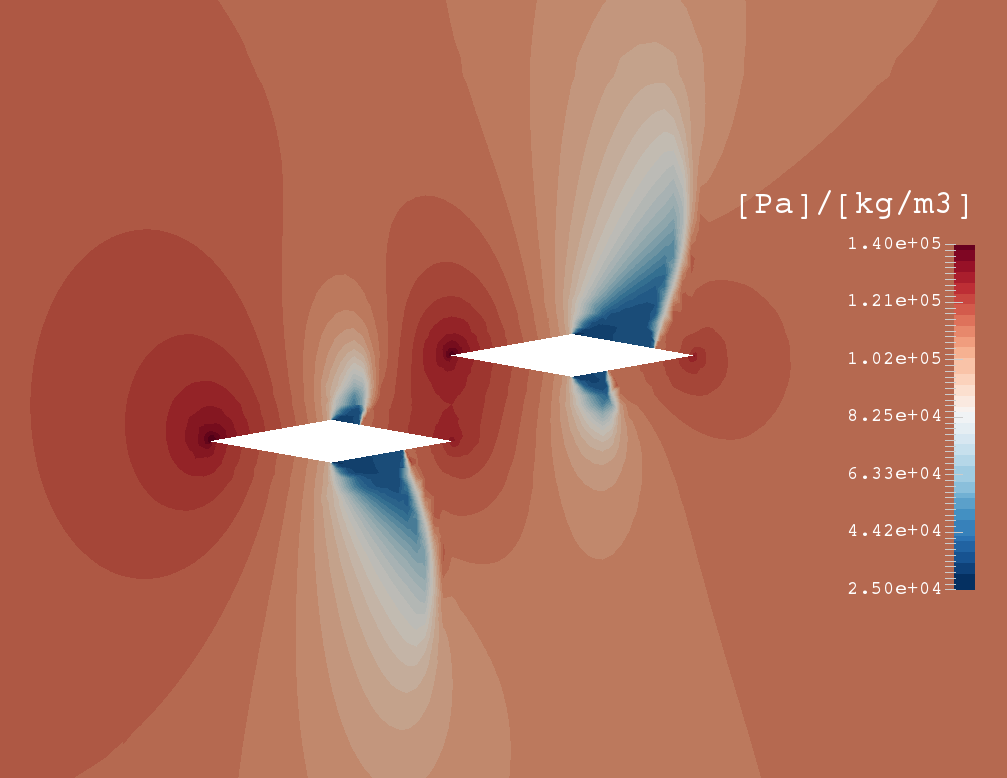 </td>
</tr></table>
(a) 0.52 m @ 258.2 m/s and (b) 0.99 m @ 258.2 m/s


<table><tr>
    <td> 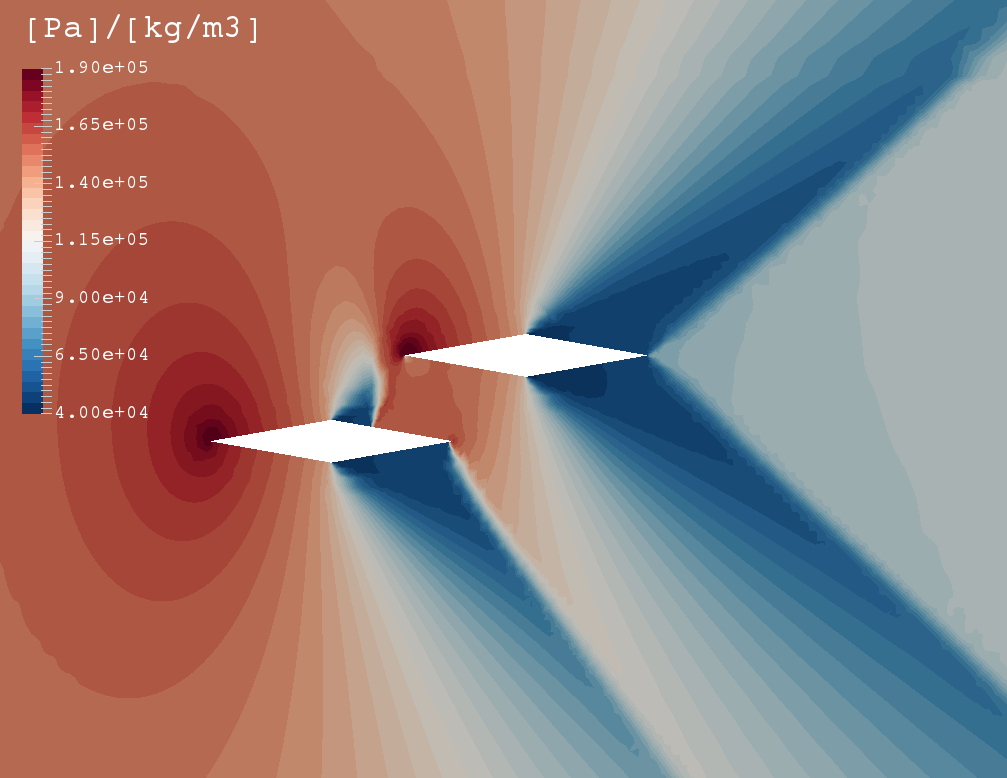 </td>
    <td> 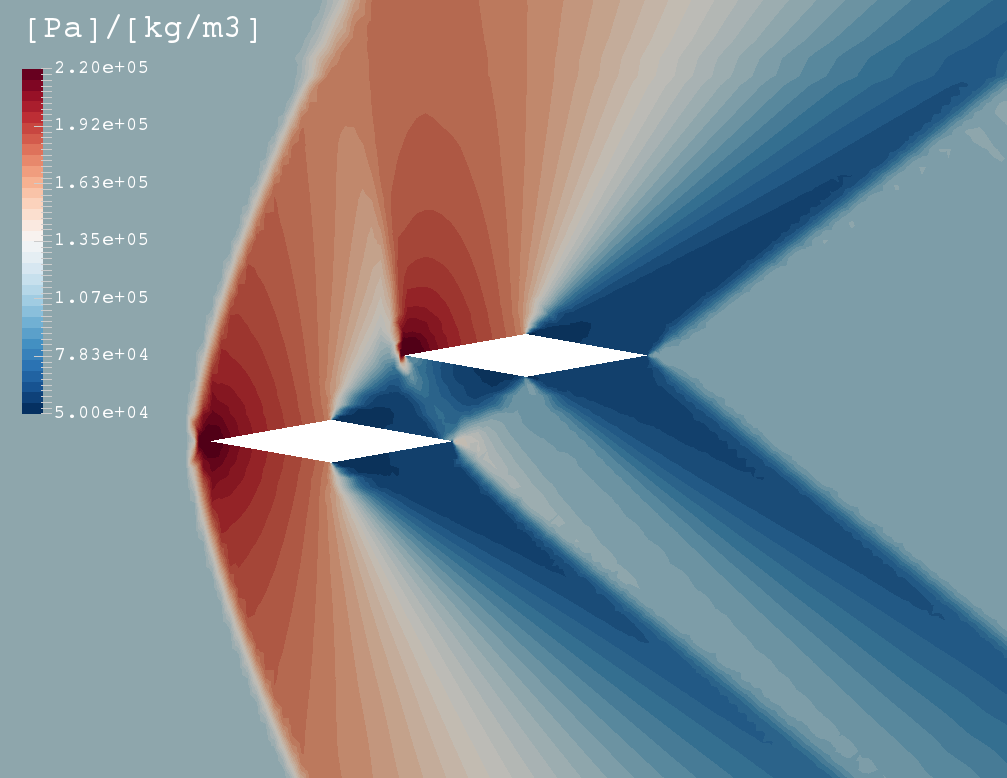 </td>
</tr></table>
(c) 0.88 m @ 361.6 m/s and (d) 0.99 m @ 427.4 m/s



<table><tr>
    <td> 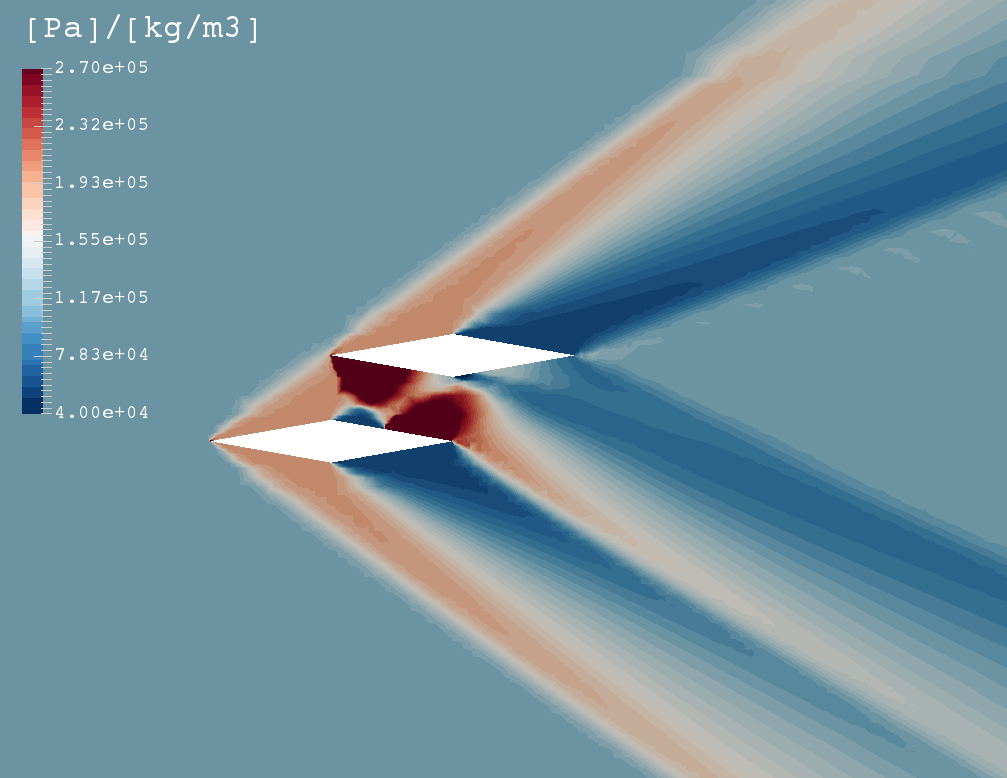 </td>
    <td> 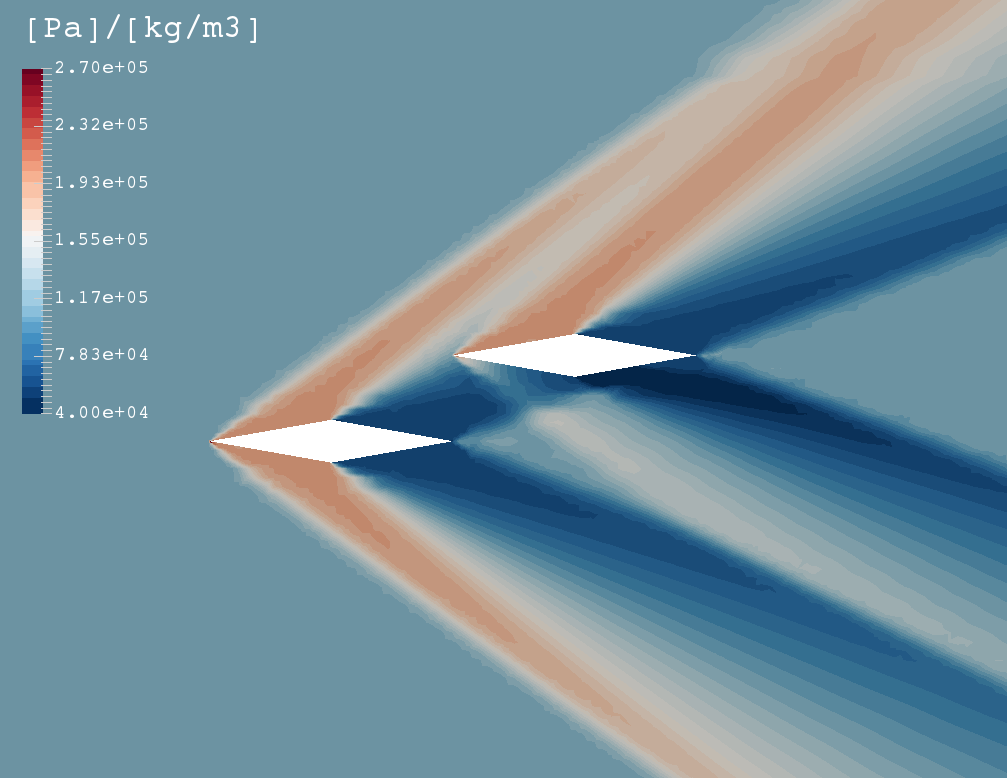 </td>
</tr></table>

(e) 0.5 m @ 700 m/s and (f) 1.0 m @ 700 m/s 



## Extracted Lift, Drag and Moment Coefficients:



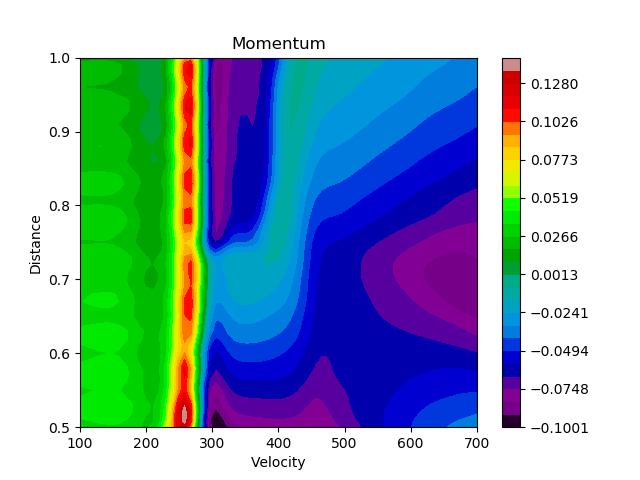


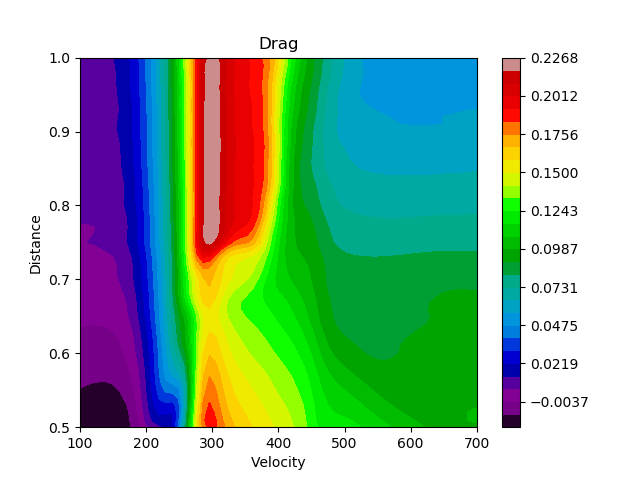


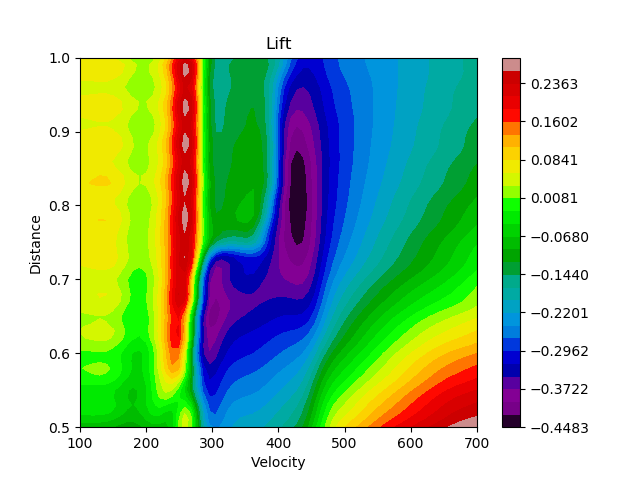
    
   

In [2]:
# Lif coefficients are in a *.csv file:
CLdata = open('Lift_coefficient.csv','r').read()

print(CLdata)

Velocity, Distance, Lift
226.31579200, 0.86842105, 0.10970189
352.63157800, 0.65789473, -0.35271566
573.68420800, 0.50000000, 0.18034628
447.36842200, 0.97368421, -0.32904739
700.00000000, 0.78947368, -0.07813563
636.84210400, 0.92105263, -0.18148451
100.00000000, 0.89473684, 0.06405676
605.26315600, 0.68421053, -0.06698574
510.52631800, 0.60526316, -0.07108189
194.73684400, 1.00000000, 0.03385756
163.15789600, 0.63157895, 0.00503439
384.21052600, 0.81578947, -0.19813060
542.10526600, 0.84210527, -0.23682504
415.78947400, 0.52631579, -0.18549452
131.57894800, 0.76315789, 0.07478438
257.89473400, 0.55263158, -0.04806623
321.05263000, 0.94736842, -0.15016475
289.47368200, 0.73684211, -0.08184528
478.94737000, 0.71052631, -0.27740481
668.42105200, 0.57894737, 0.14895566
342.10526200, 0.57894737, -0.29059485
178.94736700, 0.52631579, -0.06847859
231.57894700, 0.51754386, -0.02439939
139.47368350, 0.51315789, -0.06173833
173.68421200, 0.92105263, 0.03514634
147.36842200, 1.00000000, 0.05788

In [15]:
#
# points where the surrogate model is evaluated 
Vs = np.linspace(100,700,51)
Ds = np.linspace(0.5,1,51)
# mesh grid og points
Vx,Dx = np.meshgrid(Vs,Ds)
VDx = np.c_[Vx.flatten(),Dx.flatten()]
#
#
# read data from the text file into usefull arrays:
CL_data = np.genfromtxt('Lift_coefficient.csv',delimiter=',')[1:]
x_i = CL_data[:,:2]
f_i = CL_data[:,-1]

print(" >> NUMBER OF POINTS : %i"%f_i.size)



# define the funtion to print the coeffient
def plotfig(CLx,cmap=cm.nipy_spectral,levels=np.linspace(-0.45,0.3,50),x_p = x_i):
    fig = plt.figure(figsize=(8,6))
    ax1 = fig.add_subplot(111)
    cf1 = ax1.contourf(Vs,Ds,CLx.reshape(51,-1),cmap=cmap,levels=levels)
    ax1.plot(x_p[:,0],x_p[:,1],'ks',ms=7)
    cb1 = plt.colorbar(cf1,ax=ax1)
    ax1.set_xlabel('True Velocity',fontsize=14)
    ax1.set_ylabel('Distance',fontsize=14)
    
    return fig



 >> NUMBER OF POINTS : 200



 >> Kernel Length Scale = 1.7721 


 >> Initial cross-validation error = 1.1778 



/home/jaco/Documents/RBF/python_examples/surrogate.py:929: RuntimeWarning: divide by zero encountered in double_scalars
  w_k = PHIinv*f_mod



 >> Kernel Length Scale = 2.3224 


 >> Final cross-validation error = 1.1045 



<IPython.core.display.Javascript object>


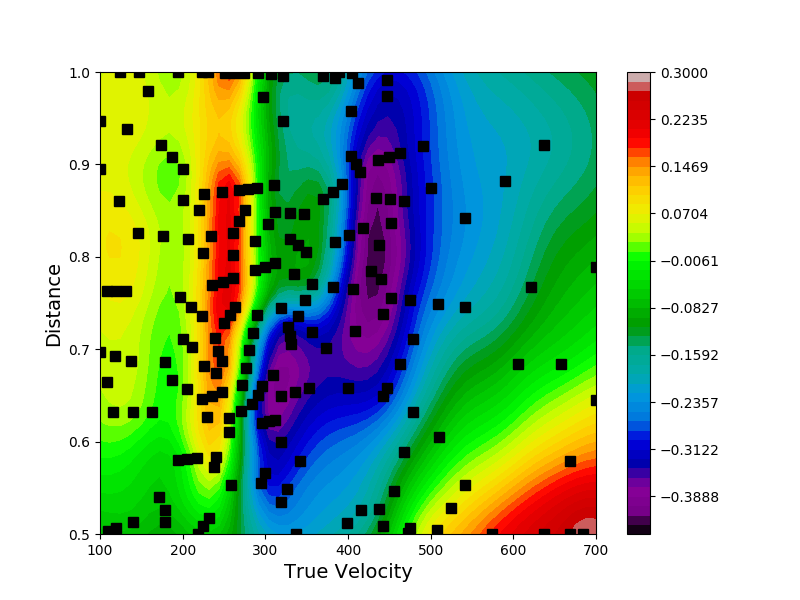

In [16]:
std_CL = True#False
#

# plot the naive surrogate:
CL_rbf = sg.rbf(x_i,f_i,function='compact_support',standardise=std_CL)

print("\n >> Kernel Length Scale = %.4f \n"%CL_rbf.epsilon)

if std_CL:
    print("\n >> Initial cross-validation error = %.4f \n"%CL_rbf.cross_validate(bins=10))

    CL_rbf.fit(using='cross-validation',bins=10)
    print("\n >> Kernel Length Scale = %.4f \n"%CL_rbf.epsilon)
    print("\n >> Final cross-validation error = %.4f \n"%CL_rbf.cross_validate(bins=10))

CLx = CL_rbf(VDx)

fig = plotfig(CLx)


<IPython.core.display.Javascript object>


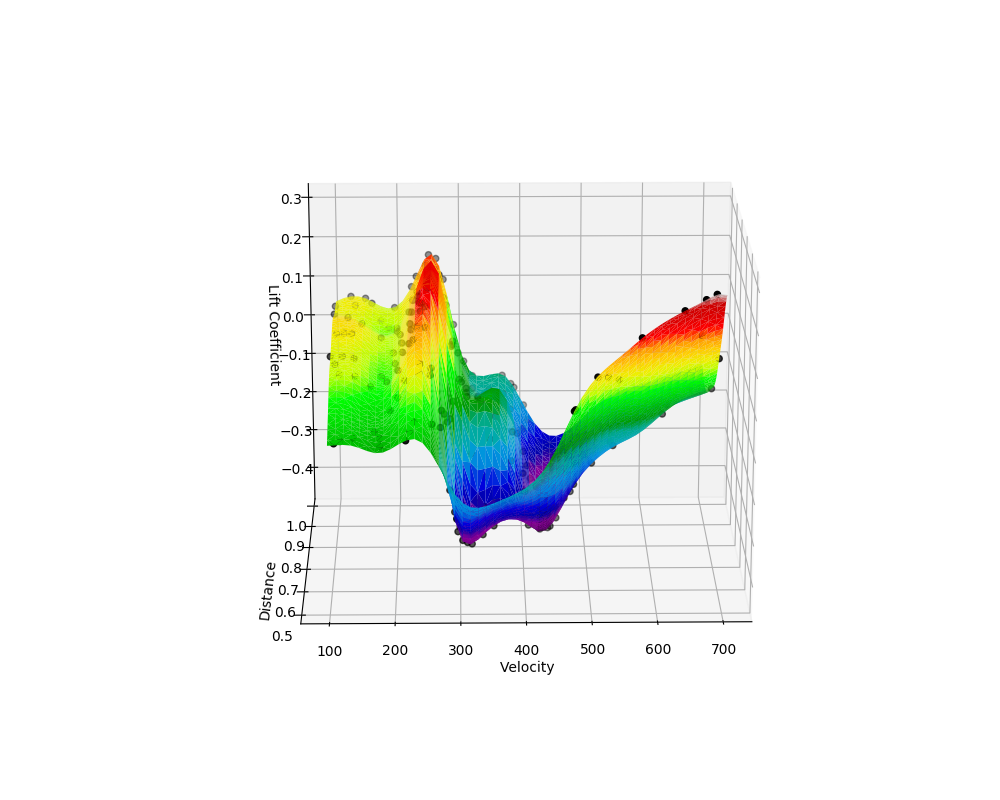

Text(0.5,0,'Lift Coefficient')

In [17]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d');
ax.plot_trisurf(Vx.flatten(),Dx.flatten(), CLx.flatten(), cmap=cm.nipy_spectral,linewidth=0.2, antialiased=True);
ax.scatter3D(CL_data[:,0],CL_data[:,1],CL_data[:,2],c='k')
ax.set_xlabel('Velocity')
ax.set_ylabel('Distance')
ax.set_zlabel('Lift Coefficient')

<IPython.core.display.Javascript object>


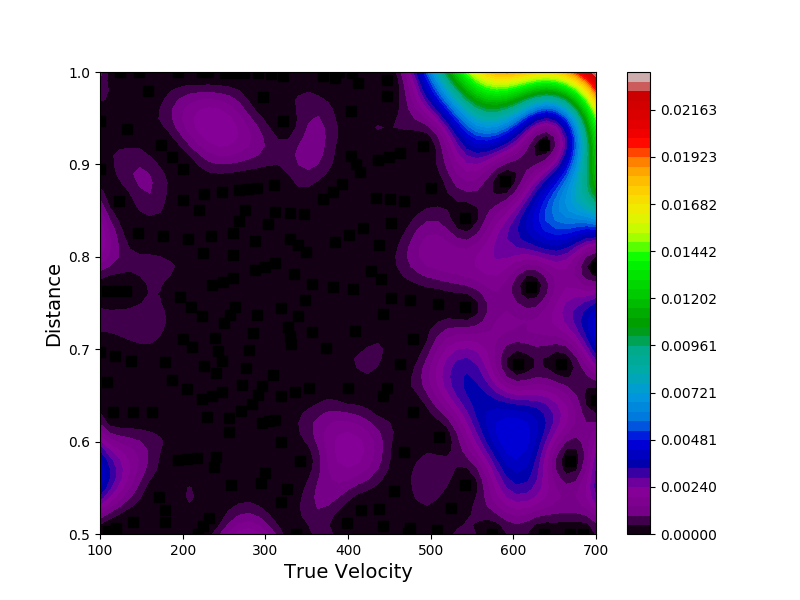

In [20]:
#
#
# CONSTRUCT A SAMPLING FUNCTION:
#
# Uncertainty / estimated RMSE
CLx,CLrmse = CL_rbf(VDx,error=True)
fig = plotfig(CLrmse,levels=np.linspace(0.,max(CLrmse),50))





<IPython.core.display.Javascript object>


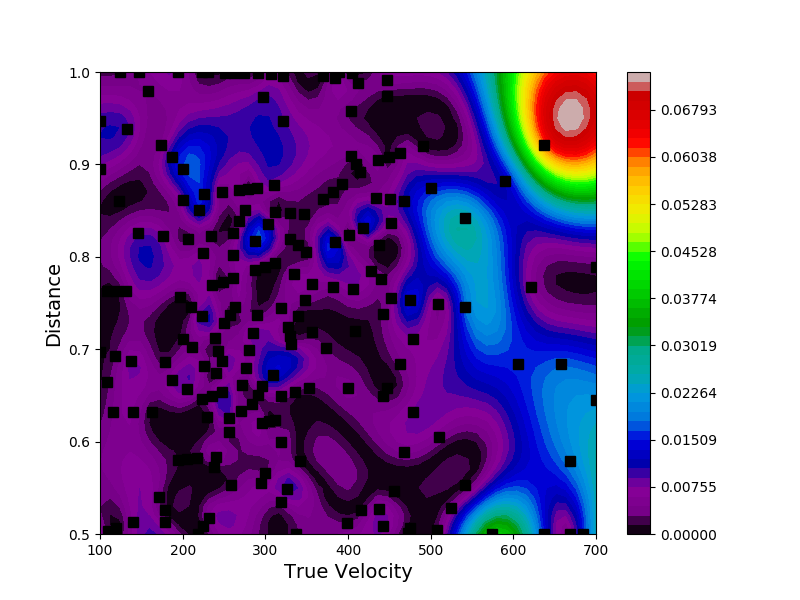

In [21]:


#
#
# >> if cross-validation error has been performed, these is a "per-sample" cross validation error value [f_xve]:
XVE_rbf = sg.rbf(x_i,
                 CL_rbf.f_xve,
                 function='compact_support',
                 epsilon=CL_rbf.epsilon,
                 standardise=True)

XVEx = XVE_rbf(VDx)
fig = plotfig(abs(XVEx),levels=np.linspace(0.,max(XVEx),50))
